<a href="https://colab.research.google.com/github/Dhritidhawan/AI-Assignments/blob/main/Assignment8_DhritiDhawan_1024150370.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

100%|██████████| 26.4M/26.4M [00:01<00:00, 15.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 271kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.02MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 17.8MB/s]

Training set has 60000 instances
Validation set has 10000 instances


As always, let's visualize the data as a sanity check:


T-shirt/top  T-shirt/top  Shirt  T-shirt/top


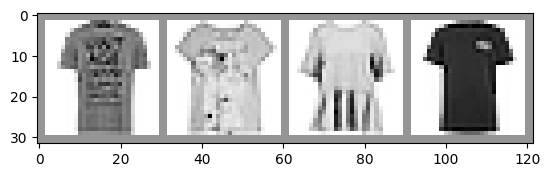

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

The Model
=========

The model we'll use in this example is a variant of LeNet-5 - it should
be familiar if you've watched the previous videos in this series.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total learnable parameters: {total_params}")

Total learnable parameters: 44426


Loss Function
=============

For this example, we'll be using a cross-entropy loss. For demonstration
purposes, we'll create batches of dummy output and label values, run
them through the loss function, and examine the result.


In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.2757, 0.9743, 0.7832, 0.9785, 0.4155, 0.5194, 0.2437, 0.0903, 0.3591,
         0.7518],
        [0.9947, 0.3689, 0.7746, 0.1121, 0.5976, 0.7062, 0.9388, 0.2880, 0.5309,
         0.0706],
        [0.3832, 0.5062, 0.8837, 0.0233, 0.1335, 0.2505, 0.9600, 0.0708, 0.2815,
         0.8942],
        [0.2924, 0.3329, 0.3458, 0.6360, 0.4499, 0.8539, 0.1474, 0.1533, 0.8260,
         0.8026]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.3846213817596436


Optimizer
=========

For this example, we'll be using simple [stochastic gradient
descent](https://pytorch.org/docs/stable/optim.html) with momentum.

It can be instructive to try some variations on this optimization
scheme:

-   Learning rate determines the size of the steps the optimizer takes.
    What does a different learning rate do to the your training results,
    in terms of accuracy and convergence time?
-   Momentum nudges the optimizer in the direction of strongest gradient
    over multiple steps. What does changing this value do to your
    results?
-   Try some different optimization algorithms, such as averaged SGD,
    Adagrad, or Adam. How do your results differ?


In [ ]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

The Training Loop
=================

Below, we have a function that performs one training epoch. It
enumerates data from the DataLoader, and on each pass of the loop does
the following:

-   Gets a batch of training data from the DataLoader
-   Zeros the optimizer's gradients
-   Performs an inference - that is, gets predictions from the model for
    an input batch
-   Calculates the loss for that set of predictions vs. the labels on
    the dataset
-   Calculates the backward gradients over the learning weights
-   Tells the optimizer to perform one learning step - that is, adjust
    the model's learning weights based on the observed gradients for
    this batch, according to the optimization algorithm we chose
-   It reports on the loss for every 1000 batches.
-   Finally, it reports the average per-batch loss for the last 1000
    batches, for comparison with a validation run


In [ ]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            running_loss = 0.

    return last_loss

Per-Epoch Activity
==================

There are a couple of things we'll want to do once per epoch:

-   Perform validation by checking our relative loss on a set of data
    that was not used for training, and report this
-   Save a copy of the model

Here, we'll do our reporting in TensorBoard. This will require going to
the command line to start TensorBoard, and opening it in another browser
tab.


In [ ]:
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))


    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}'.format(epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 2.0760031194686888
  batch 2000 loss: 0.9720495104007423
  batch 3000 loss: 0.7858079225020483
  batch 4000 loss: 0.6740043961899355
  batch 5000 loss: 0.6515734497169032
  batch 6000 loss: 0.6248039000972639
  batch 7000 loss: 0.5767962713036686
  batch 8000 loss: 0.5979916204917245
  batch 9000 loss: 0.5455047190808691
  batch 10000 loss: 0.5265405169292353
  batch 11000 loss: 0.5278351892018691
  batch 12000 loss: 0.5160410860045813
  batch 13000 loss: 0.4750965318674571
  batch 14000 loss: 0.4685510535771027
  batch 15000 loss: 0.44647272493690254
LOSS train 0.44647272493690254 valid 0.47063061594963074
EPOCH 2:
  batch 1000 loss: 0.4496953232868691
  batch 2000 loss: 0.4441811203525867
  batch 3000 loss: 0.4226799379638396
  batch 4000 loss: 0.45869407261454037
  batch 5000 loss: 0.4059689728608355
  batch 6000 loss: 0.40561926444293933
  batch 7000 loss: 0.4442132103907061
  batch 8000 loss: 0.3969092410063022
  batch 9000 loss: 0.40035806963493814
  b

To load a saved version of the model:

``` {.python}
saved_model = GarmentClassifier()
saved_model.load_state_dict(torch.load(PATH))
```

Once you've loaded the model, it's ready for whatever you need it for
-more training, inference, or analysis.

Note that if your model has constructor parameters that affect model
structure, you'll need to provide them and configure the model
identically to the state in which it was saved.



In [ ]:
saved_model = GarmentClassifier()

In [ ]:
# To load a saved version of the model:
PATH = 'model_4'  # Replace with the desired model path
saved_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>